In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
# import lime.lime_tabular as lime_tab
import lime.lime_tabular_mod as lime_tab
import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
75,6.6,3.0,4.4,1.4,Iris-versicolor
21,5.1,3.7,1.5,0.4,Iris-setosa
13,4.3,3.0,1.1,0.1,Iris-setosa
41,4.5,2.3,1.3,0.3,Iris-setosa
76,6.8,2.8,4.8,1.4,Iris-versicolor
...,...,...,...,...,...
87,6.3,2.3,4.4,1.3,Iris-versicolor
69,5.6,2.5,3.9,1.1,Iris-versicolor
88,5.6,3.0,4.1,1.3,Iris-versicolor
14,5.8,4.0,1.2,0.2,Iris-setosa


### Prepare dataset 

In [3]:
labels_column_name = "label"
# jackknife_idx = random.choice(iris_dataset.index.to_numpy())
jackknife_idx = 118
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

result = model.predict(test_x)
accuracy = sklearn.metrics.accuracy_score(test_y, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-virginica']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime_tab.LimeTabularExplainerMod(
    train_x,
    feature_names = attributes,
    class_names = model.classes_,
    with_kfold = 5
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
probabilities = model.predict_proba(test_x)[0,:]
probabilities_for_labels = {}
for label, probability in zip(model.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 1.0}


Explain the instance

c:\users\kamil zych\documents\mgr\lime\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


array([0., 0., 1.])

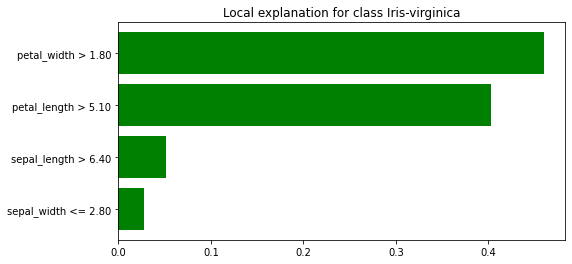

In [7]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3
)
fig = explanation.as_pyplot_figure(explanation.top_labels[0])
fig.set_size_inches(8, 4)
fig.savefig("default_explanation.png", dpi=100,  bbox_inches='tight', pad_inches=0.2)
fig.show()
explanation.predict_proba   # probabilites from explained model

In [9]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))

[0.0, 0.0, 1.0]
[-0.023186774797440246, 0.007286320500107024, 1.0159004542973329]
[0.0, 0.0071212025, 0.9928788]


In [10]:
print("MSE on training set:", np.array(explanation.get_losses_for_surrogate_model()))
print("MSE on cv-test  set:", np.mean(explanation.get_losses_for_cv_model(), axis=1))
print("std on cv-test  set:", np.std(explanation.get_losses_for_cv_model(), axis=1))

MSE on training set: [0.07599416 0.05317783 0.02530757]
MSE on cv-test  set: [0.07613452 0.05325885 0.0253714 ]
std on cv-test  set: [0.00333968 0.00264405 0.00220471]


In [11]:
explanation.get_losses_for_cv_model(out="raw")

array([[0.07779555, 0.07970933, 0.07239875, 0.07183851, 0.07893045],
       [0.05467795, 0.05603727, 0.05157892, 0.04889923, 0.05510085],
       [0.02708942, 0.02839939, 0.02212695, 0.02513527, 0.02410597]])

In [12]:
explanation.get_fidelity_loss_on_kfold("raw")


array([0.05318702, 0.05471289, 0.04870082, 0.0486225 , 0.05271126])